To validate the approximated LOOCV for Logistic regression and Logistic ridge regression,
we used three dataset, one is random normal data, second is the fludata.

Firstly, we validate the approximated leave-one-out formula.

# Experiments 1: Random Generated data

In [36]:
import numpy as np
import matplotlib.pyplot as plt
import time

from tqdm import tqdm

from utils import *

In [50]:
np.random.seed(42)

n = 500 # number of data
p = 4 # number of feature (including intercept)
k = 500 # number of repetition

X_all = np.hstack([np.ones((n * k, 1)), np.random.normal(size=(n * k, p-1))])
beta_all = np.random.normal(size=(p * k, 1))
eps_all = np.random.normal(size=(n * k, 1))
y_all = []
for j in range(k):
    y_all.append( X_all[j*n:(j+1)*n,] @ beta_all[j*p:(j+1)*p, ] + eps_all[j*n:(j+1)*n, ]) 
y_all = np.vstack(y_all)
y_binary_all = (sigmoid(y_all)  >= 0.5).astype("int")

In [51]:
alphas = [10**(i-3) for i in range(7)]

## 1.1. LOOCV for linear regression and ridge regression

In [52]:
time_linear = []
time_linear_loocv = []

press_linear = []
press_linear_loocv = []

for j in range(k):
    X, y = X_all[j*n:(j+1)*n,], y_all[j*n:(j+1)*n,]
    
    time1 = time.time()
    press_linear.append(linear_press(X, y))
    time_linear.append(time.time() - time1)

    time2 = time.time()
    press_linear_loocv.append(linear_loocv(X, y))
    time_linear_loocv.append(time.time() - time2)

In [53]:
all_same(press_linear, press_linear_loocv)

True

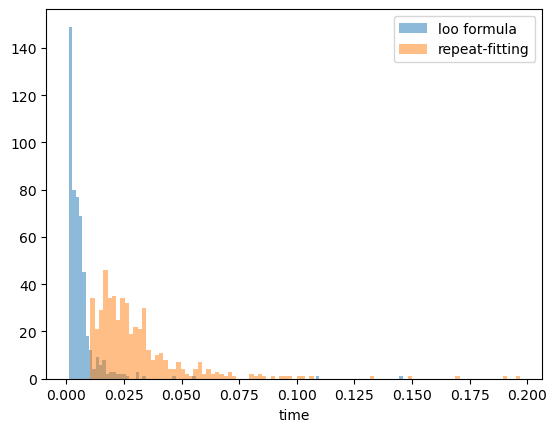

In [73]:
plt.hist(time_linear, alpha = 0.5, label = "loo formula", bins=100)
plt.hist(time_linear_loocv, alpha = 0.5, label = "repeat-fitting", bins=100)
plt.xlabel("time")
# plt.title("Time calculating PRESS by loo formula and repeat-fitting")
plt.legend()
plt.show()

## 1.2. Ridge regression

In [57]:
def ridge_press(X, y, alpha):
    n, p = X.shape
    I = np.identity(n)
    H = X @ inv(X.T @ X + alpha * np.identity(p)) @ X.T 
    rss = y.T @ (I - H) @ np.diag(np.diag(I - H) ** (-2)) @ (I - H) @ y 
    return rss.item()


def ridge_loocv(X, y, alpha):
    n, p = X.shape
    eps = []
    for i in range(n):
        X_i, y_i = X[np.arange(X.shape[0]) != i], y[np.arange(y.shape[0]) != i]
        beta_i = inv(X_i.T @ X_i + alpha * np.identity(p)) @ X_i.T @ y_i     
        eps.append( y[i] - X[i] @ beta_i ) 
    return np.sum(np.array(eps) ** 2)

In [58]:
time_ridge = []
time_ridge_loocv = []

for alpha in alphas:    
    rec1 = []
    rec2 = []

    press_ridge = []
    press_ridge_loocv = []

    for j in range(k):
        X, y = X_all[j*n:(j+1)*n,], y_all[j*n:(j+1)*n,]
        
        time1 = time.time()
        press_ridge.append(ridge_press(X, y, alpha))
        rec1.append(time.time() - time1)

        time2 = time.time()
        press_ridge_loocv.append(ridge_loocv(X, y, alpha))
        rec2.append(time.time() - time2)
    if all_same(press_ridge, press_ridge_loocv):
        print(f"Two are same when alpha = {alpha}")

    time_ridge.append(np.mean(rec1))
    time_ridge_loocv.append(np.mean(rec2))
    

Two are same when alpha = 0.001
Two are same when alpha = 0.01
Two are same when alpha = 0.1
Two are same when alpha = 1
Two are same when alpha = 10
Two are same when alpha = 100
Two are same when alpha = 1000


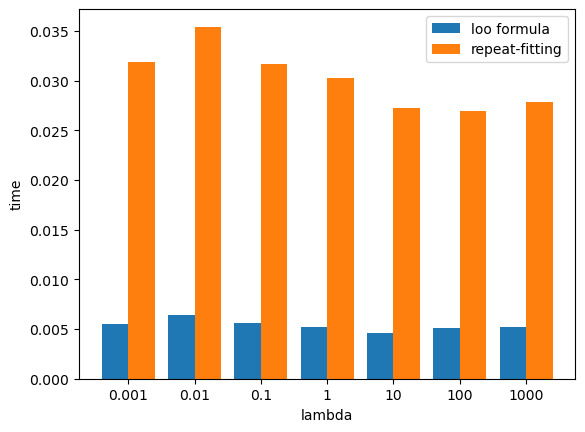

In [74]:
plt.bar(np.arange(7)-0.2, time_ridge, 0.4, label="loo formula")
plt.bar(np.arange(7)+0.2, time_ridge_loocv, 0.4, label="repeat-fitting")
plt.xticks(np.arange(7), alphas)
plt.xlabel("lambda")
plt.ylabel("time")
# plt.title("Average time calculate Ridge PRESS by loo formula and repeat-fitting")
plt.legend()
plt.show()

## 1.3. Approximated LOOCV for Logistic regression

In [6]:
time_log = []
time_log_loocv = []

err_log = []
err_log_loocv = []

for j in range(k):
    # simulate data
    X, y = X_all[j*n:(j+1)*n,], y_binary_all[j*n:(j+1)*n,]

    time1 = time.time()
    beta_approx, approx_err = logistic_approx(X, y)
    time_log.append(time.time() - time1)

    time2 = time.time()
    beta_loocv, loocv_err = logistic_loocv(X, y)
    time_log_loocv.append(time.time() - time2)

    err_log.append(np.mean(approx_err))
    err_log_loocv.append(np.mean(loocv_err))
        

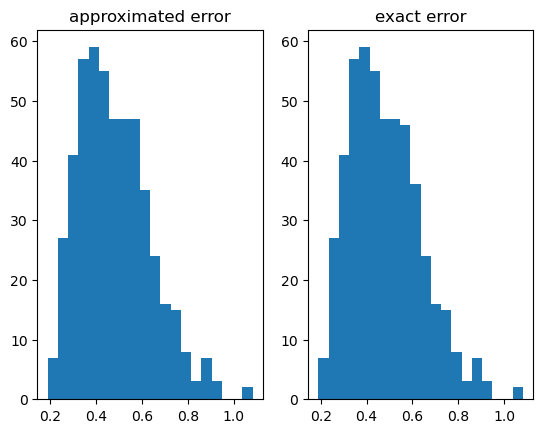

In [27]:
fig, axes = plt.subplots(1, 2)
axes[0].hist(err_log, bins=20)
axes[1].hist(err_log_loocv, bins=20)
axes[0].set_title("approximated error")
axes[1].set_title("exact error")
plt.show()


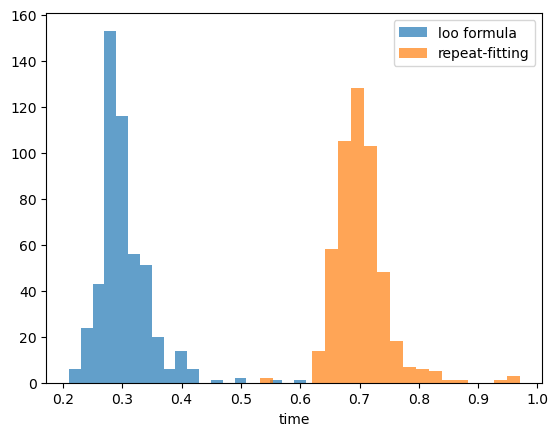

In [75]:
plt.hist(time_log, bins=20, alpha=0.7, label="loo formula")
plt.hist(time_log_loocv, bins=20, alpha=0.7, label="repeat-fitting")
plt.xlabel("time")
# plt.title("Time get out-of-sample error by loo formula and repeat-fitting")
plt.legend()
plt.show()

## 1.4. Approximated LOOCV for Logistic ridge

In [37]:
time_logrid = []
time_logrid_loocv = []

err_logrid = []
err_logrid_loocv = []

for alpha in tqdm(alphas):
    time_rec1, time_rec2 = [], []
    err_rec1, err_rec2 = [], []
    
    for j in tqdm(range(k)):
        # simulate data
        X, y = X_all[j*n:(j+1)*n,], y_binary_all[j*n:(j+1)*n,]

        time1 = time.time()
        _, err_approx = logistic_ridge_approx(X, y, alpha)
        time_rec1.append(time.time() - time1)

        time2 = time.time()
        _, err_loocv = logistic_ridge_loocv(X, y, alpha)
        time_rec2.append(time.time() - time2)
        
        err_rec1.append(np.mean(err_approx))
        err_rec2.append(np.mean(err_loocv))

    time_logrid.append(np.mean(time_rec1))
    time_logrid_loocv.append(np.mean(time_rec2))
    err_logrid.append(np.mean(err_rec1))
    err_logrid_loocv.append(np.mean(err_rec2))

100%|██████████| 7/7 [50:23<00:00, 431.90s/it]


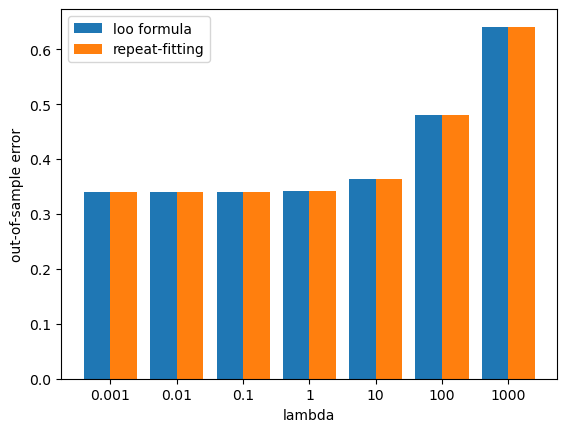

In [71]:
plt.bar(np.arange(7)-0.2, err_logrid, 0.4, label="loo formula")
plt.bar(np.arange(7)+0.2, err_logrid_loocv, 0.4, label="repeat-fitting")
plt.xticks(np.arange(7), alphas)
plt.xlabel("lambda")
plt.ylabel("out-of-sample error")
# plt.title("Out-of-sample error calculated by loo formula and repeat-fitting")
plt.legend()
plt.show()

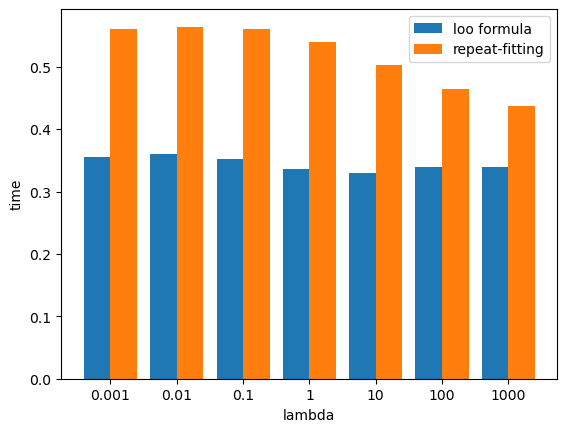

In [70]:
plt.bar(np.arange(7)-0.2, time_logrid, 0.4, label="loo formula")
plt.bar(np.arange(7)+0.2, time_logrid_loocv, 0.4, label="repeat-fitting")
plt.xticks(np.arange(7), alphas)
plt.xlabel("lambda")
plt.ylabel("time")
# plt.title("Time by loo formula and repeat-fitting")
plt.legend()
plt.show()